# Load Data

In [ ]:
!wget https://github.com/mojtaba1995/WebTest/raw/master/ForamGeneration/ForamGeneration.zip
!unzip ./ForamGeneration.zip
!rm -rf ./ForamGeneration.zip
!rm -rf ./sample_data

In [ ]:
import glob

trainpath = 'Training'
trainlabelpath = 'Training-Depth'
testpath = 'Testing'

training_data = glob.glob(trainpath+"/*/*.png")
training_label_data = glob.glob(trainlabelpath+"/*/*.png")
test_data = glob.glob(testpath+"/*/*.png")

print (len(training_data))
print (len(training_label_data))
print("number of training classes = " + str(len(training_label_data)/10))
print (len(test_data))
print("number of test classes = " + str(len(test_data)/40))
training_label_data=sorted(training_label_data)
print(training_label_data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx]

In [ ]:
from PIL import Image
import numpy as np

newsize = (64, 64)
X = np.zeros((39200, newsize[0], newsize[1],1))
Y = np.zeros((39200, newsize[0], newsize[1],1))

X_aug = np.zeros((39200, newsize[0], newsize[1],1))
Y_aug = np.zeros((39200, newsize[0], newsize[1],1))

training_classes = []
for i in range(0, len(training_label_data)):
  tmp = training_label_data[i]
  training_classes.append(tmp[15:19])

training_classes = list(dict.fromkeys(training_classes))

for i in range(0, len(training_classes)):
  label_dir_name = training_classes[i]
  for j in range(0,10):
    for k in range(0,4):
      X_tmp = np.array(Image.open(trainpath+"/"+label_dir_name+"_"+str(j+1)+"/"+str(k+1)+".png").convert('L'))
      # scale from [0,255] to [-1,1]
      X_tmp = (X_tmp - 127.5) / 127.5
      X_tmp = crop_center(X_tmp, newsize[0], newsize[1])
      X_aug[i+(j)*980+(k)*9800,:,:,:] = X_tmp.reshape((newsize[0], newsize[1],1))

      X_tmp = np.array(Image.open(trainpath+"/"+label_dir_name+"_"+str(j+1)+"/"+str(k+1)+".png").convert('L').resize(newsize))
      # scale from [0,255] to [-1,1]
      X_tmp = (X_tmp - 127.5) / 127.5
      X[i+(j)*980+(k)*9800,:,:,:] = X_tmp.reshape((newsize[0], newsize[1],1))

      Y_tmp = np.array(Image.open(trainlabelpath+"/"+label_dir_name+"_"+str(j+1)+"/"+"depth"+".png").convert('L'))
      # scale from [0,255] to [-1,1]
      Y_tmp = (Y_tmp - 127.5) / 127.5
      Y_tmp = crop_center(Y_tmp, newsize[0], newsize[1])
      Y_aug[i+(j)*980+(k)*9800,:,:,:] = Y_tmp.reshape((newsize[0], newsize[1],1))

      Y_tmp = np.array(Image.open(trainlabelpath+"/"+label_dir_name+"_"+str(j+1)+"/"+"depth"+".png").convert('L').resize(newsize))
      # scale from [0,255] to [-1,1]
      Y_tmp = (Y_tmp - 127.5) / 127.5
      Y[i+(j)*980+(k)*9800,:,:,:] = Y_tmp.reshape((newsize[0], newsize[1],1))


In [ ]:
print(X.shape)
print(Y.shape)
print(X_aug.shape)
print(Y_aug.shape)
#print(X[0])

(39200, 64, 64, 1)
(39200, 64, 64, 1)
(39200, 64, 64, 1)
(39200, 64, 64, 1)


In [ ]:
from numpy.random import randint

ix = randint(0, X_aug.shape[0], 50000-39200)
X = np.concatenate((X, X_aug[ix]), axis=0)
Y = np.concatenate((Y, Y_aug[ix]), axis=0)
X_aug = []
Y_aug = []

In [ ]:
print(X.shape)
print(Y.shape)

(50000, 64, 64, 1)
(50000, 64, 64, 1)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X = []
Y = []

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(40000, 64, 64, 1)
(40000, 64, 64, 1)
(10000, 64, 64, 1)
(10000, 64, 64, 1)


# Show sample data

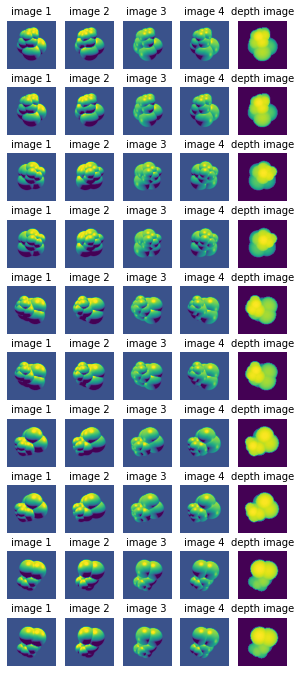

In [ ]:
import cv2
import matplotlib.pyplot as plt

im = []

for j in range (10):
  #print(training_label_data[j])
  #print(trainpath+"/"+label_dir_name[15:-10]+"/1.png")
  label_dir_name = training_label_data[j]
  X1 = cv2.imread(trainpath+"/"+label_dir_name[15:-10]+"/1.png",cv2.IMREAD_GRAYSCALE)
  X2 = cv2.imread(trainpath+"/"+label_dir_name[15:-10]+"/2.png",cv2.IMREAD_GRAYSCALE)
  X3 = cv2.imread(trainpath+"/"+label_dir_name[15:-10]+"/3.png",cv2.IMREAD_GRAYSCALE)
  X4 = cv2.imread(trainpath+"/"+label_dir_name[15:-10]+"/4.png",cv2.IMREAD_GRAYSCALE)
  Y5 = cv2.imread(label_dir_name,cv2.IMREAD_GRAYSCALE)
  tmp = [X1, X2, X3,X4,Y5]
  im.append(tmp)


plt.figure(figsize=(5, 12))

#for images, labels in train_ds.take(1):
for i in range(50):
  ax = plt.subplot(10, 5, i + 1)
  tmp=im[i//10]
  plt.imshow(tmp[i%5])
  plt.axis('off')

  if((i%5)!=4):
    plt.title("image "+str((i+1)%5),fontsize=10)
  else:
    plt.title("depth image",fontsize=10)

# Define Generator and Discriminator Models

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
import numpy as np
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [ ]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

In [ ]:
def chamfer_loss_value(y_true, y_pred):

    # flatten the batch
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)

    y_pred_mask_f = K.sigmoid(y_pred_f - 0.5)

    finalChamferDistanceSum = K.sum(y_pred_mask_f * y_true_f, axis=1, keepdims=True)

    return K.mean(finalChamferDistanceSum)

In [ ]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=chamfer_loss_value(dis_out), optimizer=opt)
	#model.compile(loss='mse', optimizer=opt)
	return model

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(n_samples, patch_shape, current_indx):
	X1, X2 = X_train[current_indx:current_indx+n_samples], Y_train[current_indx:current_indx+n_samples]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X1 = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X1), patch_shape, patch_shape, 1))
	return X1, y

# Discriminator

In [ ]:
image_shape = (64,64,1)
# weight initialization
init = RandomNormal(stddev=0.02)
	# source image input
in_src_image = Input(shape=image_shape)
	# target image input
in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
merged = Concatenate()([in_src_image, in_target_image])
	# C64
d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
d = LeakyReLU(alpha=0.2)(d)
print(d)
	# C128
d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
d = BatchNormalization()(d)
d = LeakyReLU(alpha=0.2)(d)
print(d)
	# C256
d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
d = BatchNormalization()(d)
d = LeakyReLU(alpha=0.2)(d)
print(d)
	# C512
d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
d = BatchNormalization()(d)
d = LeakyReLU(alpha=0.2)(d)
print(d)
	# second last output layer
d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
d = BatchNormalization()(d)
d = LeakyReLU(alpha=0.2)(d)
print(d)
	# patch output
d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
print(d)
patch_out = Activation('sigmoid')(d)
print(patch_out)
	# define model
model = Model([in_src_image, in_target_image], patch_out)
# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
model.compile(loss=chamfer_loss_value(patch_out), optimizer=opt)
d_model = model

# Generator

In [ ]:
image_shape = (64,64,1)
	# weight initialization
init = RandomNormal(stddev=0.02)
	# image input
in_image = Input(shape=image_shape)
	# encoder model
print(in_image)
e1 = define_encoder_block(in_image, 64, batchnorm=False)
print("e1",e1)
e2 = define_encoder_block(e1, 128)
print("e2",e2)
e3 = define_encoder_block(e2, 256)
print("e3",e3)
e4 = define_encoder_block(e3, 512)
print("e4",e4)
e5 = define_encoder_block(e4, 512)
print("e5",e5)
#e6 = define_encoder_block(e5, 512)
#print("e6",e6)
#e7 = define_encoder_block(e6, 512)
#print(e7)
	# bottleneck, no batch norm and relu
b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e5)
b = Activation('relu')(b)
	# decoder model
print("b",b)
#print(e7)
#d1 = decoder_block(b, e7, 512)
#d2 = decoder_block(b, e6, 512)
d3 = decoder_block(b, e5, 512)
d4 = decoder_block(d3, e4, 512, dropout=False)
d5 = decoder_block(d4, e3, 256, dropout=False)
d6 = decoder_block(d5, e2, 128, dropout=False)
print("d6",d6)
d7 = decoder_block(d6, e1, 64, dropout=False)
print("d7",d7)
	# output
g = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
out_image = Activation('tanh')(g)
print(out_image)
	# define model
model = Model(in_image, out_image)
g_model = model

Tensor("input_3:0", shape=(None, 64, 64, 1), dtype=float32)
e1 Tensor("leaky_re_lu_5/LeakyRelu:0", shape=(None, 32, 32, 64), dtype=float32)
e2 Tensor("leaky_re_lu_6/LeakyRelu:0", shape=(None, 16, 16, 128), dtype=float32)
e3 Tensor("leaky_re_lu_7/LeakyRelu:0", shape=(None, 8, 8, 256), dtype=float32)
e4 Tensor("leaky_re_lu_8/LeakyRelu:0", shape=(None, 4, 4, 512), dtype=float32)
e5 Tensor("leaky_re_lu_9/LeakyRelu:0", shape=(None, 2, 2, 512), dtype=float32)
b Tensor("activation_1/Relu:0", shape=(None, 1, 1, 512), dtype=float32)
d6 Tensor("activation_5/Relu:0", shape=(None, 16, 16, 256), dtype=float32)
d7 Tensor("activation_6/Relu:0", shape=(None, 32, 32, 128), dtype=float32)
Tensor("activation_7/Tanh:0", shape=(None, 64, 64, 1), dtype=float32)


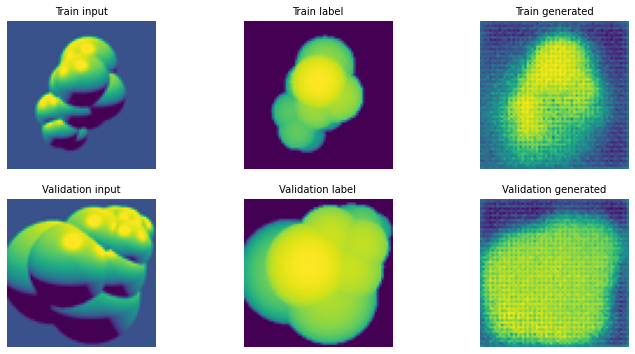

In [ ]:
img= []

ix1 = randint(0, X_train.shape[0], 1)
tmp = X_train[ix1]
img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

tmp = Y_train[ix1]
img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

tmp = X_train[ix1]
tmp = g_model.predict(tmp.reshape((1,tmp.shape[1],tmp.shape[2],1)))
img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

ix2 = randint(0, X_test.shape[0], 1)
tmp = X_test[ix2]
img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

tmp = Y_test[ix2]
img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

tmp = Y_test[ix2]
tmp = g_model.predict(tmp.reshape((1,tmp.shape[1],tmp.shape[2],1)))
img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

w=tmp.shape[1]
h=tmp.shape[2]

plt.figure(figsize=(12, 6))

columns = 3
rows = 2
ax = []
title = ["Train input", "Train label", "Train generated", "Validation input", "Validation label", "Validation generated"]

for i in range(1, columns*rows +1):
  ax = plt.subplot(rows, columns, i)
  plt.axis('off')
  plt.title(title[i-1], fontsize=10)
  plt.imshow(img[i-1])
plt.show()

bat_per_epo 100
n_steps 1000
===========  EPOCH = 0  ===========
Validation Set Loss = 42.073543548583984


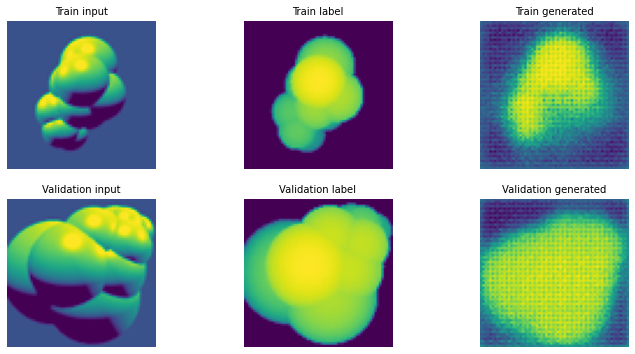

>5, d1[0.036] d2[0.048] g[34.977]
>10, d1[0.045] d2[0.046] g[27.739]
>15, d1[0.678] d2[0.348] g[23.629]
>20, d1[0.064] d2[0.065] g[19.042]
>25, d1[0.042] d2[0.044] g[16.684]
>30, d1[2.841] d2[0.015] g[14.400]
>35, d1[0.301] d2[0.308] g[13.116]
>40, d1[0.142] d2[0.170] g[11.874]
>45, d1[0.316] d2[0.146] g[11.211]
>50, d1[0.024] d2[0.032] g[10.073]
>55, d1[0.031] d2[0.026] g[9.751]
>60, d1[0.020] d2[0.042] g[9.202]
>65, d1[0.384] d2[0.495] g[9.514]
>70, d1[0.424] d2[0.395] g[8.774]
>75, d1[0.393] d2[0.393] g[7.780]
>80, d1[0.398] d2[0.375] g[8.155]
>85, d1[0.399] d2[0.367] g[7.647]
>90, d1[0.381] d2[0.381] g[7.376]
>95, d1[0.371] d2[0.391] g[7.763]
>100, d1[0.363] d2[0.406] g[8.735]
===========  EPOCH = 1  ===========
Validation Set Loss = 7.858598232269287


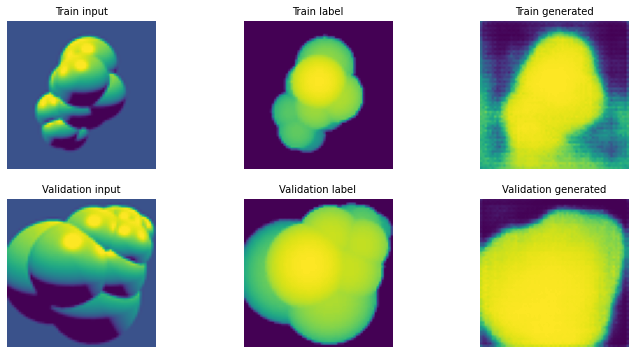

>105, d1[0.358] d2[0.370] g[7.655]
>110, d1[0.376] d2[0.355] g[7.189]
>115, d1[0.347] d2[0.366] g[7.613]
>120, d1[0.374] d2[0.337] g[8.115]
>125, d1[0.354] d2[0.343] g[6.806]
>130, d1[0.312] d2[0.391] g[6.954]
>135, d1[0.304] d2[0.329] g[6.673]
>140, d1[0.423] d2[0.362] g[6.712]
>145, d1[0.384] d2[0.387] g[7.554]
>150, d1[0.382] d2[0.339] g[6.875]
>155, d1[0.318] d2[0.354] g[6.785]
>160, d1[0.413] d2[0.294] g[6.557]
>165, d1[0.298] d2[0.317] g[6.445]
>170, d1[0.370] d2[0.360] g[6.706]
>175, d1[0.294] d2[0.388] g[6.224]
>180, d1[0.337] d2[0.339] g[6.458]
>185, d1[0.261] d2[0.266] g[6.294]
>190, d1[0.273] d2[0.293] g[6.433]
>195, d1[0.601] d2[0.258] g[5.818]
>200, d1[0.344] d2[0.358] g[5.892]
===========  EPOCH = 2  ===========
Validation Set Loss = 6.567112445831299


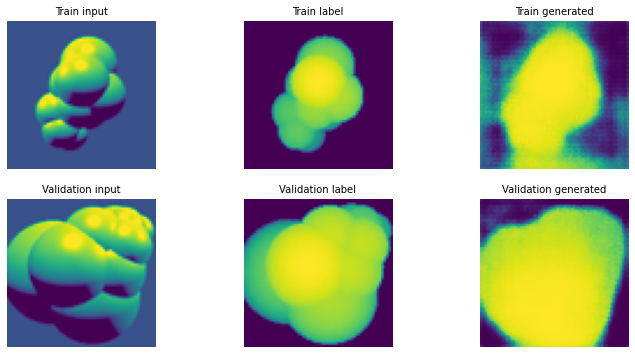

>205, d1[0.367] d2[0.337] g[5.673]
>210, d1[0.350] d2[0.298] g[6.806]
>215, d1[0.248] d2[0.291] g[6.062]
>220, d1[0.344] d2[0.525] g[6.537]
>225, d1[0.380] d2[0.368] g[6.129]
>230, d1[0.345] d2[0.371] g[5.764]
>235, d1[0.337] d2[0.356] g[5.620]
>240, d1[0.362] d2[0.338] g[5.650]
>245, d1[0.374] d2[0.338] g[5.806]
>250, d1[0.296] d2[0.334] g[5.490]
>255, d1[0.348] d2[0.281] g[5.361]
>260, d1[0.516] d2[0.523] g[6.181]
>265, d1[0.396] d2[0.397] g[5.617]
>270, d1[0.383] d2[0.389] g[5.452]
>275, d1[0.360] d2[0.403] g[5.482]
>280, d1[0.371] d2[0.380] g[5.239]
>285, d1[0.392] d2[0.359] g[5.554]
>290, d1[0.384] d2[0.364] g[5.466]
>295, d1[0.373] d2[0.368] g[5.433]
>300, d1[0.380] d2[0.361] g[5.469]
===========  EPOCH = 3  ===========
Validation Set Loss = 5.557138919830322


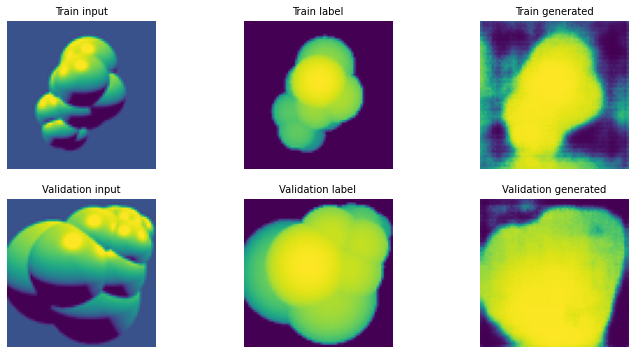

>305, d1[0.369] d2[0.368] g[5.021]
>310, d1[0.378] d2[0.353] g[5.429]
>315, d1[0.382] d2[0.346] g[5.296]
>320, d1[0.331] d2[0.359] g[5.306]
>325, d1[0.265] d2[0.467] g[5.904]
>330, d1[0.347] d2[0.334] g[5.036]
>335, d1[0.312] d2[0.252] g[5.054]
>340, d1[0.380] d2[0.373] g[4.820]
>345, d1[0.365] d2[0.381] g[5.264]
>350, d1[0.361] d2[0.371] g[4.862]
>355, d1[0.367] d2[0.371] g[5.224]
>360, d1[0.381] d2[0.341] g[5.211]
>365, d1[0.345] d2[0.353] g[5.544]
>370, d1[0.371] d2[0.329] g[4.818]
>375, d1[0.362] d2[0.363] g[5.093]
>380, d1[0.379] d2[0.319] g[4.968]
>385, d1[0.227] d2[0.499] g[4.985]
>390, d1[0.356] d2[0.247] g[4.812]
>395, d1[0.222] d2[0.378] g[4.582]
>400, d1[0.263] d2[0.138] g[4.967]
===========  EPOCH = 4  ===========
Validation Set Loss = 5.20793342590332


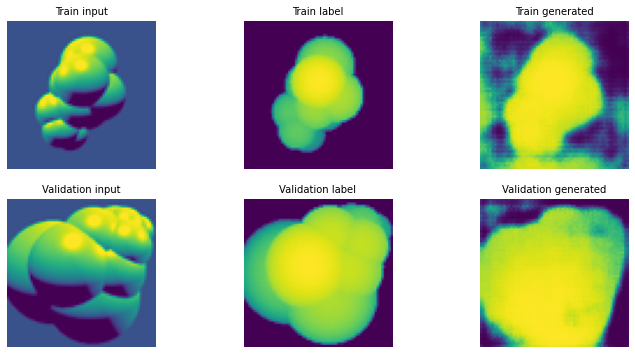

>405, d1[0.368] d2[0.488] g[5.121]
>410, d1[0.632] d2[0.430] g[4.776]
>415, d1[0.123] d2[0.146] g[4.939]
>420, d1[0.127] d2[0.098] g[4.691]
>425, d1[0.141] d2[0.070] g[4.775]
>430, d1[0.354] d2[0.724] g[6.170]
>435, d1[0.273] d2[0.278] g[5.004]
>440, d1[0.320] d2[0.309] g[5.297]
>445, d1[0.055] d2[0.057] g[5.275]
>450, d1[0.034] d2[0.032] g[4.859]
>455, d1[0.026] d2[0.025] g[4.464]
>460, d1[0.025] d2[0.020] g[4.493]
>465, d1[0.020] d2[0.019] g[4.746]
>470, d1[0.026] d2[0.020] g[4.176]
>475, d1[0.030] d2[0.020] g[4.538]
>480, d1[0.025] d2[0.021] g[4.568]
>485, d1[0.038] d2[0.014] g[4.230]
>490, d1[0.024] d2[0.018] g[4.302]
>495, d1[0.015] d2[0.013] g[3.901]
>500, d1[0.022] d2[0.019] g[4.228]
===========  EPOCH = 5  ===========
Validation Set Loss = 4.611440658569336


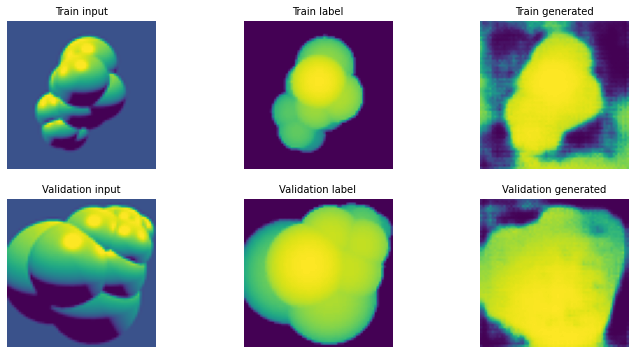

>505, d1[0.019] d2[0.012] g[4.068]
>510, d1[0.023] d2[0.015] g[4.150]
>515, d1[0.014] d2[0.009] g[4.366]
>520, d1[0.009] d2[0.011] g[4.491]
>525, d1[0.013] d2[0.011] g[4.077]
>530, d1[0.451] d2[0.435] g[7.543]
>535, d1[0.446] d2[0.273] g[4.808]
>540, d1[0.361] d2[0.305] g[4.249]
>545, d1[0.397] d2[0.209] g[3.772]
>550, d1[0.439] d2[0.207] g[4.074]
>555, d1[0.159] d2[0.307] g[3.964]
>560, d1[0.090] d2[0.049] g[4.025]
>565, d1[0.489] d2[0.519] g[4.379]
>570, d1[0.088] d2[0.066] g[3.743]
>575, d1[0.032] d2[0.016] g[3.707]
>580, d1[0.013] d2[0.010] g[3.847]
>585, d1[0.015] d2[0.009] g[3.782]
>590, d1[0.014] d2[0.012] g[3.980]
>595, d1[0.007] d2[0.011] g[3.862]
>600, d1[0.009] d2[0.012] g[3.863]
===========  EPOCH = 6  ===========
Validation Set Loss = 4.336521625518799


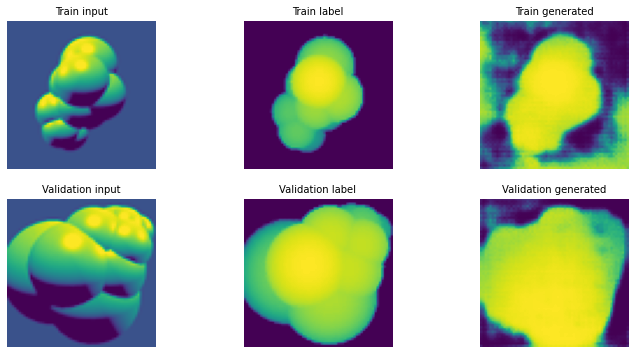

>605, d1[0.014] d2[0.007] g[3.885]
>610, d1[0.006] d2[0.007] g[4.107]
>615, d1[0.008] d2[0.007] g[4.007]
>620, d1[0.008] d2[0.005] g[3.645]
>625, d1[0.006] d2[0.006] g[3.635]
>630, d1[0.008] d2[0.005] g[3.756]
>635, d1[0.007] d2[0.005] g[3.640]
>640, d1[0.013] d2[0.007] g[4.062]
>645, d1[0.007] d2[0.004] g[3.742]
>650, d1[0.007] d2[0.005] g[3.745]
>655, d1[0.006] d2[0.004] g[3.674]
>660, d1[0.004] d2[0.004] g[3.701]
>665, d1[0.009] d2[0.003] g[3.574]
>670, d1[0.004] d2[0.004] g[3.562]
>675, d1[0.006] d2[0.003] g[3.562]
>680, d1[0.004] d2[0.005] g[3.703]
>685, d1[0.005] d2[0.003] g[3.908]
>690, d1[0.005] d2[0.003] g[3.424]
>695, d1[0.003] d2[0.003] g[3.455]
>700, d1[0.006] d2[0.003] g[3.232]
===========  EPOCH = 7  ===========
Validation Set Loss = 4.156974792480469


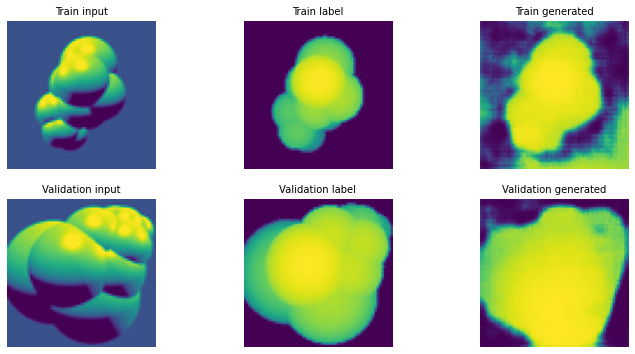

>705, d1[0.004] d2[0.003] g[4.009]
>710, d1[0.004] d2[0.004] g[3.432]
>715, d1[0.004] d2[0.004] g[3.627]
>720, d1[0.004] d2[0.003] g[3.738]
>725, d1[0.005] d2[0.005] g[3.341]
>730, d1[0.004] d2[0.002] g[3.345]
>735, d1[0.004] d2[0.003] g[3.336]
>740, d1[0.003] d2[0.006] g[3.549]
>745, d1[0.002] d2[0.004] g[3.888]
>750, d1[0.003] d2[0.003] g[3.426]
>755, d1[0.004] d2[0.004] g[3.527]
>760, d1[0.004] d2[0.002] g[3.395]
>765, d1[0.004] d2[0.003] g[3.136]
>770, d1[0.003] d2[0.002] g[3.446]
>775, d1[0.002] d2[0.005] g[3.243]
>780, d1[0.003] d2[0.002] g[3.583]
>785, d1[0.003] d2[0.003] g[3.419]
>790, d1[0.002] d2[0.002] g[3.420]
>795, d1[0.007] d2[0.006] g[3.274]
>800, d1[0.004] d2[0.002] g[3.333]
===========  EPOCH = 8  ===========
Validation Set Loss = 3.843529224395752


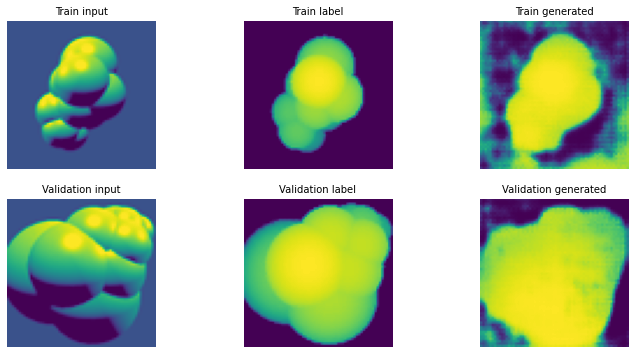

>805, d1[0.004] d2[0.002] g[3.403]
>810, d1[0.002] d2[0.002] g[3.367]
>815, d1[0.002] d2[0.002] g[3.444]
>820, d1[0.003] d2[0.002] g[3.512]
>825, d1[0.006] d2[0.002] g[3.250]
>830, d1[0.005] d2[0.002] g[3.085]
>835, d1[0.003] d2[0.002] g[3.138]
>840, d1[0.003] d2[0.001] g[3.553]
>845, d1[0.003] d2[0.002] g[3.197]
>850, d1[0.004] d2[0.001] g[3.375]
>855, d1[0.003] d2[0.002] g[3.234]
>860, d1[0.003] d2[0.003] g[3.430]
>865, d1[0.002] d2[0.001] g[2.957]
>870, d1[0.002] d2[0.005] g[3.325]
>875, d1[0.002] d2[0.003] g[3.437]
>880, d1[0.004] d2[0.005] g[3.212]
>885, d1[0.002] d2[0.002] g[3.027]
>890, d1[0.003] d2[0.003] g[3.001]
>895, d1[0.002] d2[0.001] g[3.343]
>900, d1[0.002] d2[0.003] g[3.266]
===========  EPOCH = 9  ===========
Validation Set Loss = 3.843540906906128


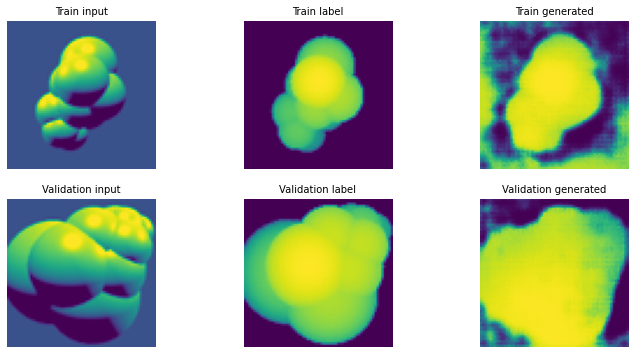

>905, d1[0.002] d2[0.002] g[3.076]
>910, d1[0.004] d2[0.003] g[3.203]
>915, d1[0.004] d2[0.001] g[3.038]
>920, d1[0.002] d2[0.002] g[3.301]
>925, d1[0.004] d2[0.001] g[3.087]
>930, d1[0.002] d2[0.002] g[3.175]
>935, d1[0.003] d2[0.002] g[3.609]
>940, d1[0.003] d2[0.001] g[3.715]
>945, d1[0.001] d2[0.001] g[3.354]
>950, d1[0.002] d2[0.001] g[2.949]
>955, d1[0.002] d2[0.002] g[2.990]
>960, d1[0.002] d2[0.002] g[3.008]
>965, d1[0.002] d2[0.001] g[2.842]
>970, d1[0.001] d2[0.003] g[3.330]
>975, d1[0.002] d2[0.002] g[3.305]
>980, d1[0.002] d2[0.001] g[3.117]
>985, d1[0.002] d2[0.002] g[3.087]
>990, d1[0.001] d2[0.003] g[2.798]
>995, d1[0.003] d2[0.002] g[3.042]
>1000, d1[0.001] d2[0.002] g[3.023]


In [ ]:
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

image_shape = (64, 64, 1)
gan_model = define_gan(g_model, d_model, image_shape)
current_indx = 0
# train pix2pix models
n_epochs = 10
n_batch = 400
# determine the output square shape of the discriminator
n_patch = d_model.output_shape[1]
# unpack dataset
#trainA, trainB = dataset
# calculate the number of batches per training epoch
bat_per_epo = int(len(X_train) / n_batch)
print("bat_per_epo",bat_per_epo)
# calculate the number of training iterations
n_steps = bat_per_epo * n_epochs
print("n_steps",n_steps)
	# manually enumerate epochs
d1_train= []
d2_train= []
gan_train = []
gan_test = []
epoch_counter = 0
for i in range(n_steps):
	# select a batch of real samples
	if(current_indx + n_batch >= len(X_train)):
		current_indx = 0
	[X_realA, X_realB], y_real = generate_real_samples(n_batch, n_patch, current_indx)
	current_indx = 	current_indx + n_batch
	# generate a batch of fake samples
	X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
	# update discriminator for real samples
	d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
	# update discriminator for generated samples
	#print(y_fake.shape)
	d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
	# update the generator
	g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
	# summarize performance
	if((i+1) % 5 == 0):
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
	if(i % bat_per_epo == 0):
		print("===========  EPOCH = "+str(epoch_counter)+"  ===========")
		epoch_counter += 1
		y = ones((len(X_test), n_patch, n_patch, 1))
		results, _, _ = gan_model.evaluate(X_test, [y, Y_test], batch_size=128, verbose=0)
		print("Validation Set Loss = " + str(results))

		img= []

		#ix = randint(0, X_train.shape[0], 1)
		#ix = 5
		tmp = X_train[ix1]
		img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

		tmp = Y_train[ix1]
		img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

		tmp = X_train[ix1]
		tmp = g_model.predict(tmp.reshape((1,tmp.shape[1],tmp.shape[2],1)))
		img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

		#ix = 5
		tmp = X_test[ix2]
		img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

		tmp = Y_test[ix2]
		img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

		tmp = Y_test[ix2]
		tmp = g_model.predict(tmp.reshape((1,tmp.shape[1],tmp.shape[2],1)))
		img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

		w=tmp.shape[1]
		h=tmp.shape[2]

		plt.figure(figsize=(12, 6))

		columns = 3
		rows = 2
		ax = []
		title = ["Train input", "Train label", "Train generated", "Validation input", "Validation label", "Validation generated"]

		for i in range(1, columns*rows +1):
			ax = plt.subplot(rows, columns, i)
			plt.axis('off')
			plt.title(title[i-1], fontsize=10)
			plt.imshow(img[i-1])
		plt.show()

		print("===================================")
		d1_train.append(d_loss1)
		d2_train.append(d_loss2)
		gan_train.append(g_loss)
		gan_test.append(results)



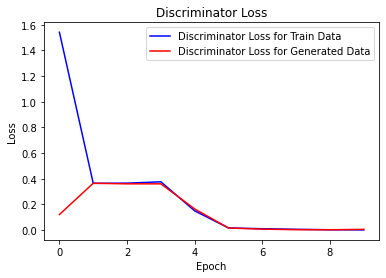

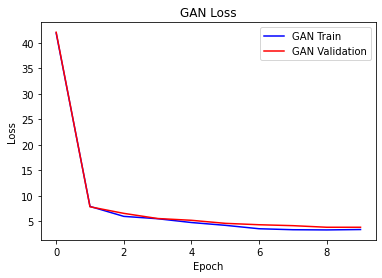

In [ ]:
def plot_history(d1_train, d2_train, gan_train, gan_test):
	  # plot loss
    plt.title('Discriminator Loss')
    plt.plot(d1_train, color='blue', label='Discriminator1 Train')
    plt.plot(d2_train, color='red', label='Discriminator1 Train')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Discriminator Loss for Train Data', 'Discriminator Loss for Generated Data'])
    plt.show()

	  # plot loss
    plt.title('GAN Loss')
    plt.plot(gan_train, color='blue', label='GAN Train')
    plt.plot(gan_test, color='red', label='GAN Validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['GAN Train', 'GAN Validation'])
    plt.show()

plot_history(d1_train, d2_train, gan_train, gan_test)


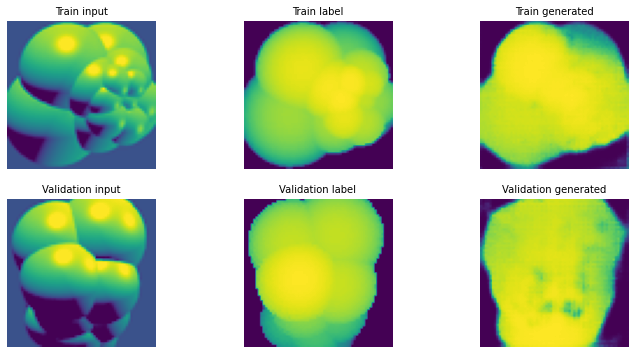

In [ ]:
img= []

ix = randint(0, X_train.shape[0], 1)
tmp = X_train[ix]
img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

tmp = Y_train[ix]
img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

tmp = X_train[ix]
tmp = g_model.predict(tmp.reshape((1,tmp.shape[1],tmp.shape[2],1)))
img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

ix = randint(0, X_test.shape[0], 1)
tmp = X_test[ix]
img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

tmp = Y_test[ix]
img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

tmp = Y_test[ix]
tmp = g_model.predict(tmp.reshape((1,tmp.shape[1],tmp.shape[2],1)))
img.append(tmp.reshape((tmp.shape[1],tmp.shape[2])))

w=tmp.shape[1]
h=tmp.shape[2]

plt.figure(figsize=(12, 6))

columns = 3
rows = 2
ax = []
title = ["Train input", "Train label", "Train generated", "Validation input", "Validation label", "Validation generated"]

for i in range(1, columns*rows +1):
  ax = plt.subplot(rows, columns, i)
  plt.axis('off')
  plt.title(title[i-1], fontsize=10)
  plt.imshow(img[i-1])
plt.show()

In [ ]:
filename2 = 'model_1.h5'
g_model.save(filename2)

In [ ]:
from PIL import Image
import numpy as np

newsize = (64, 64)
X = np.zeros((4000, newsize[0], newsize[1],1))
#Y = np.zeros((39200, newsize[0], newsize[1],1))

test_classes = []
for i in range(0, len(test_data)):
  tmp = test_data[i]
  test_classes.append(tmp[8:12])

test_classes = list(dict.fromkeys(test_classes))
#print(test_classes)
for i in range(0, len(test_classes)):
  label_dir_name = test_classes[i]
  for j in range(0,10):
    for k in range(0,4):
      X_tmp = np.array(Image.open(testpath+"/"+label_dir_name+"_"+str(j+1)+"/"+str(k+1)+".png").convert('L').resize(newsize))
      # scale from [0,255] to [-1,1]
      X_tmp = (X_tmp - 127.5) / 127.5
      X[i+(j)*100+(k)*1000,:,:,:] = X_tmp.reshape((newsize[0], newsize[1],1))
      # scale from [0,255] to [-1,1]


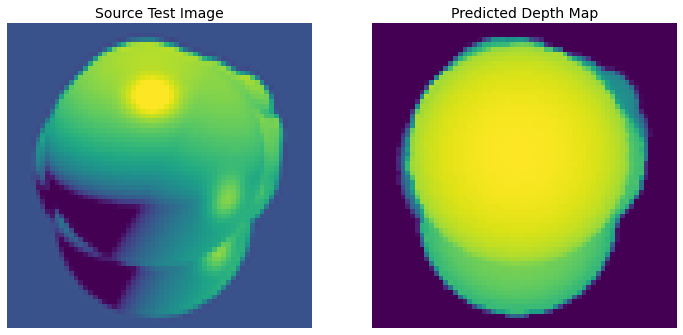

In [ ]:
from keras.models import load_model
from numpy import load
from numpy import vstack, hstack
from matplotlib import pyplot
from numpy.random import randint

# load dataset
X1 = X
model = g_model
ix = randint(0, len(X1), 1)
src_image = X1[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
gen_image = gen_image.reshape(64,64)
src_image = src_image.reshape(64,64)

im = []
im.append(src_image)
im.append(gen_image)

w=src_image.shape[0]
h=src_image.shape[1]

plt.figure(figsize=(12, 6))

columns = 2
rows = 1
ax = []
title = ["Source Test Image", "Predicted Depth Map"]

for i in range(1, columns*rows +1):
  ax = plt.subplot(rows, columns, i)
  plt.axis('off')
  plt.title(title[i-1], fontsize=14)
  plt.imshow(img[i-1])
plt.show()